In [1]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score

# Exploratory Data Analysis

In [2]:
# Load Data

train = pd.read_csv("../input/learn-ai-bbc/BBC News Train.csv")
test = pd.read_csv("../input/learn-ai-bbc/BBC News Test.csv")
sample_solution = pd.read_csv("../input/learn-ai-bbc/BBC News Sample Solution.csv")

Data Exploration:

In [3]:
# Initial Look
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Article ID and unordered cateogry shows that our data is already shuffled.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


There appears to be no missing values.

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


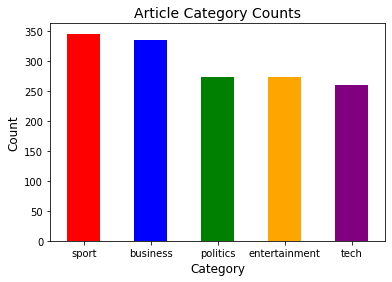

In [5]:
# Article Category Bar Plot

print(train['Category'].value_counts())
train['Category'].value_counts().plot(kind='bar', rot=0, color=['red','blue','green','orange','purple'])
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Article Category Counts", fontsize=14)
plt.show()

The number of articles in each category range from 17.5% to about 23% of the entire data, which shows that there is close to an even distribution. We can be confident this slight imbalance won't have an effect on our models.

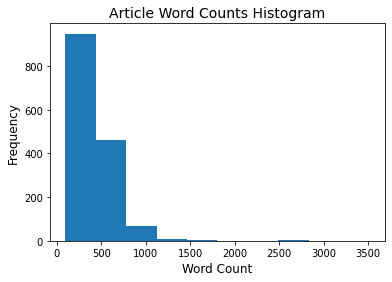

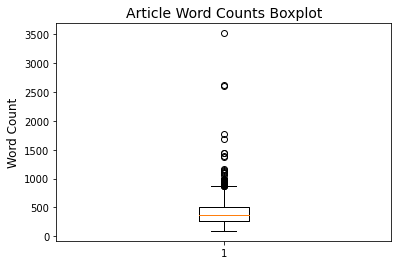

In [6]:
# Article Word Counts

word_counts = []
for i in range(len(train['Text'])):
    word_counts.append(len(train['Text'][i].strip().split(" ")))

# Histogram
plt.hist(word_counts)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Article Word Counts Histogram", fontsize=14)
plt.show()

# Boxplot
plt.boxplot(word_counts)
plt.ylabel("Word Count", fontsize=12)
plt.title("Article Word Counts Boxplot", fontsize=14)
plt.show()

The histogram above shows that the word count data is right skewed and the boxplots show that there are a number of outliers at the top end of word counts. These outliers shouldn't have an effect on classifying the category of articles so we won't address them for classification, but they may have an impact if other analysis is done.

# Model Building and Training

Before we build any models, we first must split our data into training and testing sets. We will use a random 20% of the data for testing and the remaining 80% for training.

In [7]:
x = train['Text']
y = train['Category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

To build our model we will use TFidfVectorization to remove stop words and assign 'tokens' to the remaining words. Stop words are basic, common words that are considered as uninformative.

In [8]:
vectorizer = TfidfVectorizer(min_df = 2, stop_words = 'english')
X = vectorizer.fit_transform(x_train)

Our first model using Non-Negative Matrix Factorization (NMF) will use the default 'frobenius' for beta_loss.

In [9]:
categories = 5
model = NMF(n_components = categories, init = 'random', random_state = 42)
model.fit(X)
W = model.transform(X)
H = model.components_

Since the data is word count, there are a lot of zeros. We'll build a second model with beta_loss = 'kullback-leibler'

In [10]:
model_2 = NMF(n_components = categories, init = 'random', random_state = 42, beta_loss = 'kullback-leibler', solver = 'mu')
model_2.fit(X)
W = model_2.transform(X)
H = model_2.components_

Label identification:

In [11]:
components = pd.DataFrame(H, columns = vectorizer.get_feature_names_out())
for cat in range(components.shape[0]):
    print(components.iloc[cat].nlargest(10))

mobile        0.611068
people        0.564067
said          0.475245
phone         0.446997
software      0.400582
technology    0.391756
digital       0.371433
users         0.369184
games         0.365899
music         0.339156
Name: 0, dtype: float64
film        1.046612
best        0.690757
awards      0.463146
band        0.404178
award       0.398632
actor       0.389294
music       0.380309
star        0.352018
festival    0.330458
year        0.310724
Name: 1, dtype: float64
england    0.576910
game       0.524197
win        0.427269
said       0.407839
cup        0.398803
match      0.366092
world      0.361172
club       0.357827
injury     0.356909
chelsea    0.350448
Name: 2, dtype: float64
said        0.646083
growth      0.475384
economy     0.439100
firm        0.425012
bank        0.415755
market      0.401617
company     0.389609
year        0.387956
shares      0.379287
economic    0.376643
Name: 3, dtype: float64
mr            1.146267
said          0.862807
labour  

Judging from the output above, we can infer the labels: 0:politics, 1:entertainment, 2:business, 3:tech, 4:sport.

In [12]:
# Dictionary of Category Labels to be used in testing

d = {"sport": 4, "business": 3, "tech": 2, "entertainment": 1, "politics": 0}

# Evaluation

We will test our two models on the testing data.

In [14]:
x_test_df = pd.DataFrame(x_test.sort_index())
y_test_df = pd.DataFrame(y_test.sort_index()).replace({'Category':d})

y_pred = []
for i in range(len(x_test_df)):
    X2 = vectorizer.transform(x_test_df.iloc[i])
    W2 = model.transform(X2)
    y_pred.append(pd.DataFrame(W2).idxmax(axis=1))
    
y_pred_2 = []
for i in range(len(x_test_df)):
    X3 = vectorizer.transform(x_test_df.iloc[i])
    W3 = model_2.transform(X3)
    y_pred_2.append(pd.DataFrame(W3).idxmax(axis=1))

In [15]:
print("Accuracy of Model 1 test data:", accuracy_score(y_test_df['Category'], y_pred))
print("Accuracy of Model 2 test data:", accuracy_score(y_test_df['Category'], y_pred_2))

Accuracy of Model 1 test data: 0.6040268456375839
Accuracy of Model 2 test data: 0.37583892617449666


Our first model produced an accuracy of about 0.6, or 60% on the test data, which is not great. Our second model produced an accuracy of 37.6%. The first model that uses 'frobenius' as the beta_loss performed better. These models show us that unsupervised learning does not perform quite as well as supervised where we are given labels.